# 今回の取り組み

- 両端の`N`とそれ以外の`N`を一緒に考えると難しくなるので、これらを区別する
- 両端から連続する`N`以外の`N`を欠失として変換する

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
print(os.getcwd())

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

- `preprocess.replaceNtoD.py`を作る

In [8]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from src.DAJIN2.core.clustering import clustering

reload(preprocess)
reload(classification)
reload(clustering)
reload(consensus)
reload(report)


#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/del-stx2/barcode25.fq.gz",
    "examples/del-stx2/barcode30.fq.gz",
    "examples/del-stx2/design_stx2.fa",
    "test-stx2-deletion",
    "mm10",
    True,
    14,
)

print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

# ################################################################################
# # Export fasta files as single-FASTA format
# ################################################################################
# # TODO: use yeild, not export
# for identifier, sequence in FASTA_ALLELES.items():
#     contents = "\n".join([">" + identifier, sequence]) + "\n"
#     output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
#     output_fasta.write_text(contents)
# ###############################################################################
# # Mapping with mappy
# ###############################################################################
# for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
#     name_fasta = path_fasta.stem
#     preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
#     preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
#     preprocess.mappy_align.output_sam(
#         TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
#     )
#     preprocess.mappy_align.output_sam(
#         TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
#     )
# ########################################################################
# # MIDSV conversion
# ########################################################################
# for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
#     preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
# for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
#     preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
# ###############################################################################
# # Correct CSSPLITS
# ###############################################################################
# # preprocess.correct_revititive_deletions.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
# preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
# preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

processing test-stx2-deletion...


In [4]:
from __future__ import annotations
from copy import deepcopy
from pathlib import Path

import midsv

def transpose(cssplits):
    return [list(cs) for cs in zip(*cssplits)]


def replaceNtoD(cssplits_sample, sequence):
    cssplits_replaced = deepcopy(cssplits_sample)
    for i, cssplits in enumerate(cssplits_sample):
        flag_n_start = True
        flag_n_end = True
        for j, (start, end) in enumerate(zip(cssplits, cssplits[::-1])):
            if j == (len(cssplits)+1) // 2:
                break
            if flag_n_start and start != "N":
                    flag_n_start = False
            if flag_n_end and end != "N":
                    flag_n_end = False
            if not flag_n_start and start == "N":
                cssplits_replaced[i][j] = f"-{sequence[j]}"
            if not flag_n_end and end == "N":
                j_inv = len(cssplits) - j - 1
                cssplits_replaced[i][j_inv] = f"-{sequence[j_inv]}"
    return cssplits_replaced


###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str) -> None:
    """
    Convert any `N` as deletions other than consecutive `N` from both ends
    """
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_replaced = replaceNtoD(cssplits_sample, sequence)
        midsv_cssplits = [",".join(cs) for cs in cssplits_replaced]
        # Save as a json
        for i, cssplits in enumerate(midsv_cssplits):
            midsv_sample[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))


In [5]:
cssplits_sample = [
    ["N", "N", "N", "=A", "N" , "=C", "N", "N"],
    ["N", "N", "=A", "N", "N" , "=C", "=C", "N"],
            ]
sequence = "GCAACCCC"
# print(len(cssplits))
# print(len(cssplits) // 2)

In [6]:
cssplits_replaced = replaceNtoD(cssplits_sample, sequence)

In [7]:
print(cssplits_sample)
print(cssplits_replaced)

[['N', 'N', 'N', '=A', 'N', '=C', 'N', 'N'], ['N', 'N', '=A', 'N', 'N', '=C', '=C', 'N']]
[['N', 'N', 'N', '=A', '-C', '=C', 'N', 'N'], ['N', 'N', '=A', '-A', '-C', '=C', '=C', 'N']]


### STX2大型欠失アレルを用いてreplaceNtoDの動作を確認する

In [10]:
%%bash
ls DAJINResults/

In [11]:
################################################################################
# Export fasta files as single-FASTA format
################################################################################
# TODO: use yeild, not export
for identifier, sequence in FASTA_ALLELES.items():
    contents = "\n".join([">" + identifier, sequence]) + "\n"
    output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
    output_fasta.write_text(contents)
###############################################################################
# Mapping with mappy
###############################################################################
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
    )
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )
########################################################################
# MIDSV conversion
########################################################################
for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)

In [12]:
%%bash
query="DAJINResults/.tempdir/test-stx2-deletion/sam/barcode25_splice_control.sam"
samtools sort "$query" > tmp.bam
samtools index tmp.bam

In [23]:
large_del = "a21d42f44f56"
import midsv
midsv_sample=midsv.read_jsonl("DAJINResults/.tempdir/test-stx2-deletion/midsv/barcode25_splice_control.jsonl")
for m in midsv_sample:
    if large_del in m["QNAME"]:
        break
print(m["CSSPLIT"].split(",")[1310:1350])

['=T', '=G', '=G', '=G', '=G', '=T', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [24]:
allele="control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_replaced = replaceNtoD(cssplits_sample, sequence)
midsv_cssplits = [",".join(cs) for cs in cssplits_replaced]
# Save as a json
for i, cssplits in enumerate(midsv_cssplits):
    midsv_sample[i]["CSSPLIT"] = cssplits
midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))

In [27]:
large_del = "a21d42f44f56"
import midsv
midsv_sample=midsv.read_jsonl("DAJINResults/.tempdir/test-stx2-deletion/midsv/barcode25_splice_control.jsonl")
for m in midsv_sample:
    if large_del in m["QNAME"]:
        break
print(m["CSSPLIT"].split(",")[0:5])
print(m["CSSPLIT"].split(",")[1310:1350])
print(m["CSSPLIT"].split(",")[-5:])


['N', 'N', 'N', '=C', '=C']
['=T', '=G', '=G', '=G', '=G', '=T', '-G', '-T', '-G', '-G', '-A', '-A', '-G', '-T', '-T', '-G', '-G', '-T', '-A', '-C', '-C', '-T', '-T', '-T', '-T', '-T', '-C', '-C', '-T', '-T', '-A', '-G', '-A', '-G', '-T', '-T', '-T', '-T', '-A', '-T']
['=T', '=G', '=T', '=G', '=T']


In [31]:
count = 0
for m in midsv_sample:
    if m["CSSPLIT"].endswith("N"):
        print(m["CSSPLIT"].split(",")[-5:])
        print(m["CSSPLIT"].split(",")[1310:1330])
        count += 1
    if count == 5:
        break


['=T', '=G', '=T', '=G', 'N']
['=T', '*GA', '=G', '=G', '=G', '=T', '-G', '-T', '-G', '-G', '-A', '-A', '-G', '-T', '-T', '-G', '-G', '-T', '-A', '-C']
['N', 'N', 'N', 'N', 'N']
['=T', '-G', '=G', '=G', '=G', '=T', '=G', '=T', '=G', '-G', '-A', '=A', '=G', '=T', '=T', '=G', '=G', '=T', '=A', '=C']
['N', 'N', 'N', 'N', 'N']
['-T', '-G', '-G', '-G', '-G', '-T', '-G', '-T', '-G', '-G', '-A', '-A', '-G', '-T', '-T', '-G', '-G', '-T', '-A', '-C']
['N', 'N', 'N', 'N', 'N']
['=T', '=G', '=G', '=G', '=G', '=T', '=G', '=T', '=G', '+G|+A|=G', '=A', '=A', '=G', '=T', '=T', '-G', '=G', '*TA', '=A', '=C']
['N', 'N', 'N', 'N', 'N']
['=T', '=G', '=G', '=G', '=G', '=T', '=G', '=T', '=G', '=G', '=A', '=A', '=G', '=T', '=T', '=G', '=G', '=T', '=A', '=C']


### STX2大型欠失アレルのquickstartを起動

In [3]:
%%bash
rm -rf DAJINResults/.tempdir/test-stx2-deletion
ls DAJINResults/.tempdir/

test-pm-tyr


In [5]:
%%bash
python misc/quickstart.py

processing test-stx2-deletion...
Classify...
Clustering...
Consensus call...


- 悲しいかな、まったく分類がうまく行っていませんでした…

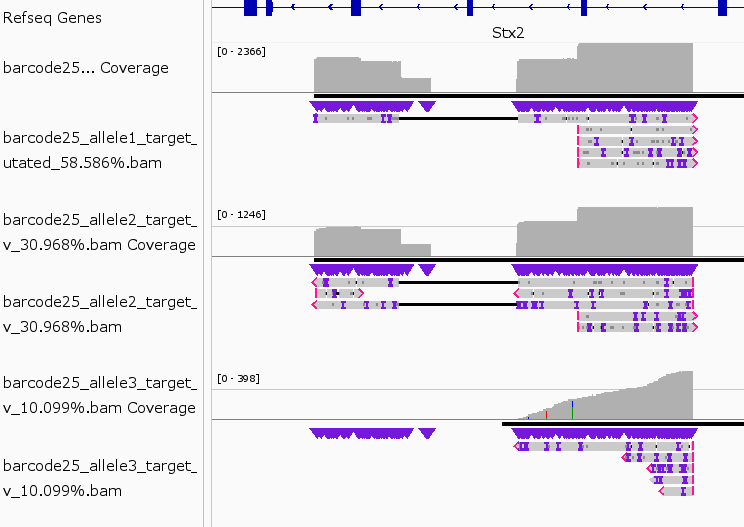

In [9]:
from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

for classif in classif_sample:
    classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

In [14]:
count = 0
for samp in classif_sample:
    if samp["SV"] == False:
        count += 1
    if count == 10:
        print(samp["QNAME"])
        print(samp["CSSPLIT"])
        break

01e43200-8ed6-4904-b4b5-35e7a68c0a37
N,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,=G,=G,=A,=T,=A,=T,=C,=

In [15]:
###############################################################################
# Mapping with mappy
###############################################################################
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
    )
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )

In [19]:
########################################################################
# MIDSV conversion
########################################################################
for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)

In [16]:
%%bash
cat DAJINResults/.tempdir/test-stx2-deletion/midsv/barcode25_splice_target.jsonl | grep 35e7a68c0a37

{"QNAME": "01e43200-8ed6-4904-b4b5-35e7a68c0a37", "RNAME": "target", "CSSPLIT": "N,=C,=T,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,*TC,*CT,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,*TC,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,*TC,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,*TG,=G,=C,=C,=C,=C,*AG,*TG,*GC,=G,=G,=A,=C,+T|=T,=C,=T,=G,=G,*CT,=T,=T,+A|+A|=A,=G,=C,*CT,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,+C|=T,+G|+G|=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,-G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,+A|+A|=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,-G,=G,=G,=C,=T,=A,=G,+T|*CT,=G,=A,=T,+G|=G,=G,=A,=G,=G,=T,+G|=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,*CT,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,+T|*CT,=G,=C,-A,*TC,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,

In [20]:
###############################################################################
# CSSPLITS Error Correction
###############################################################################
preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [21]:
###############################################################################
# Convert any `N` as deletions other than consecutive `N` from both ends
###############################################################################
preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [ ]:
%%bash
cat DAJINResults/.tempdir/test-stx2-deletion/midsv/barcode25_splice_target.jsonl | grep 35e7a68c0a37

### Error correction -> replaceNtoDの流れにして、再チャレンジ

In [22]:
%%bash
rm -rf DAJINResults/.tempdir/test-stx2-deletion
ls DAJINResults/.tempdir/

test-pm-tyr


In [23]:
%%bash
python misc/quickstart.py

processing test-stx2-deletion...
preprocessing...
Error correction...
Replace N to D...
Classify...
Clustering...
Consensus call...


In [24]:
%%bash
ls -l DAJINResults/.tempdir/test-stx2-deletion/report/HTML

total 16384
drwxrwxrwx 1 kuno kuno  512 Mar 28 06:12 barcode25
-rwxrwxrwx 1 kuno kuno 5169 Mar 28 06:25 barcode25_allele1_target_sv_32.263%.html
-rwxrwxrwx 1 kuno kuno 5194 Mar 28 06:25 barcode25_allele2_target_sv_27.063%.html
-rwxrwxrwx 1 kuno kuno 5169 Mar 28 06:25 barcode25_allele3_target_sv_21.609%.html
-rwxrwxrwx 1 kuno kuno 5198 Mar 28 06:25 barcode25_allele4_target_sv_18.581%.html
-rwxrwxrwx 1 kuno kuno 5198 Mar 28 06:25 barcode25_allele5_target_mutated_0.347%.html
-rwxrwxrwx 1 kuno kuno 5946 Mar 28 06:25 barcode25_allele6_control_sv_0.069%.html
-rwxrwxrwx 1 kuno kuno 5982 Mar 28 06:25 barcode25_allele7_inversion_sv_0.046%.html
-rwxrwxrwx 1 kuno kuno 6435 Mar 28 06:25 barcode25_allele8_control_mutated_0.023%.html


- 無事に3アレルに分離することができました

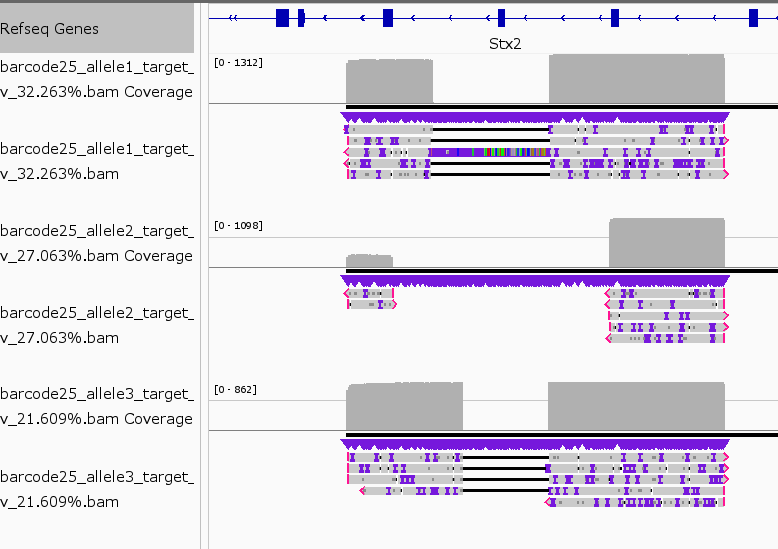

# まとめ


- `replaceNtoD`を組み込みました

# 次に取り組むこと

### Lists

+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ [ ] `preprocess.correct_sequence_error`の処理速度の改善
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする

### Focus
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか

両者については、`correct_sequence_error`などで補正するときに、**変異候補の塩基配列のみを対象とする**ことで対応できる可能性がある

- 変異候補の塩基配列のみを対象とする
    - 両端が欠失しているようなリードについて、変異候補部位を含まないリードは`uncategorized`といったカテゴリにできる
    - よって**変異候補部位を含むか含まないか**を考えることで、短いリードや両端が欠失しているリードの分類が可能になる？